In [1]:
import argparse
import sys

import tensorflow as tf
import tensorflow.contrib.slim as slim
import skimage.io as io

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNEL = 3

In [2]:
def read_caltech101(tfrecords_path):
    if 'train' in tfrecords_path:
        num_data = 6400
    else:
        num_data = 2744    
    
    num_class = 102
    items_to_descriptions = {
        'image': 'A [224 x 224 x 3] image.',
        'label': 'A single integer between 0 and 101'
    }
    
    reader = tf.TFRecordReader
    
    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='raw'),
        'image/class/label': tf.FixedLenFeature(
            [1], tf.int64, default_value=tf.zeros([1], dtype=tf.int64))
    }
    
    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL], channels=IMAGE_CHANNEL),
        'label': slim.tfexample_decoder.Tensor('image/class/label', shape=[])
    }
    
    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)
    
    return slim.dataset.Dataset(
        data_sources=tfrecords_path,
        reader=reader,
        decoder=decoder,
        num_samples=num_data,
        items_to_descriptions=items_to_descriptions,
        labels_to_names=None)

def load_batch(dataset, batch_size=32, common_queue_capacity=256, common_queue_min=128, num_threads=4, name=None):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        common_queue_capacity=common_queue_capacity,
        common_queue_min=common_queue_min)
    
    image, label = data_provider.get(['image', 'label'])
    
    images, labels = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity=4*batch_size+(num_threads+2)*3*batch_size,
        min_after_dequeue=4*batch_size,
        num_threads=num_threads,
        name=name)
    
    return images, labels    

In [3]:
def main(_):
    tfrecords_path = FLAGS.record
    
    with tf.device('/cpu:0'):
        dataset = read_caltech101(tfrecords_path)
        images, labels = load_batch(dataset)
        
    init_op = tf.global_variables_initializer()
    
    sess_config = tf.ConfigProto()
    sess_config.gpu_options.allow_growth = True
    
    with tf.Session(config=sess_config) as sess:
        
        sess.run(init_op)
        
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                images_np, labels_np = sess.run([images, labels])

                print('\n%d-th batch' % (i+1))
                print('label: ', labels_np[0])
                io.imshow(images_np[0])
                io.show()

                print('label: ', labels_np[1])
                io.imshow(images_np[1])
                io.show()

                print('label: ', labels_np[2])
                io.imshow(images_np[2])
                io.show()


1-th batch
label:  1


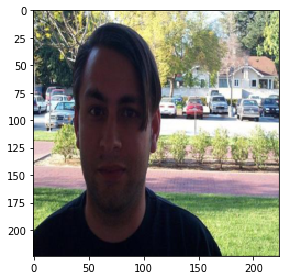

label:  54


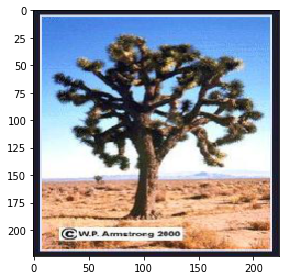

label:  91


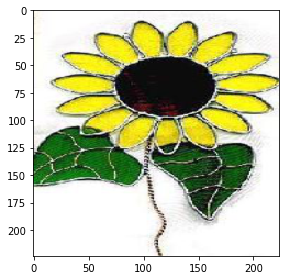


2-th batch
label:  6


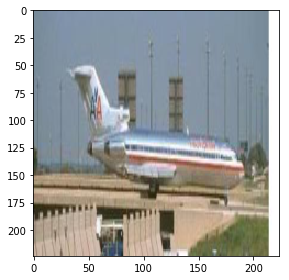

label:  95


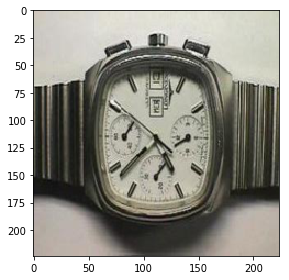

label:  48


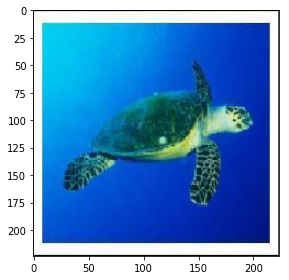


3-th batch
label:  47


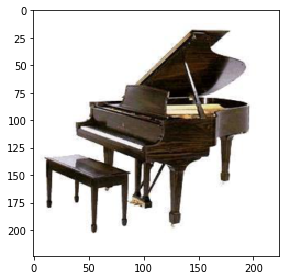

label:  33


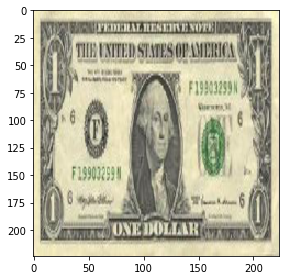

label:  24


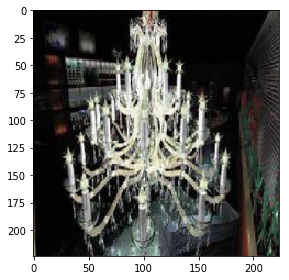


4-th batch
label:  95


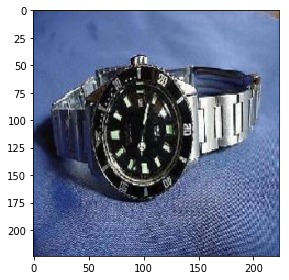

label:  32


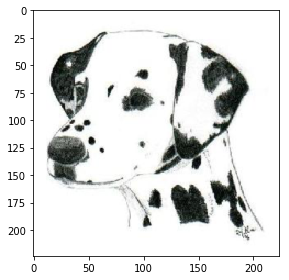

label:  0


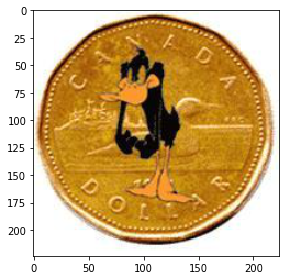

SystemExit: 

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2855: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--record',
        type=str,
        default='data/custom_train.tfrecords'
    )
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)